In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import make_data as md
import utils

In [2]:
# Directly load combined and cleaned data. Otherwise run next section to create.
df = pd.read_csv('data/all_clean_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22632 entries, 0 to 22631
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           22632 non-null  int64 
 1   processed_text  22632 non-null  object
dtypes: int64(1), object(1)
memory usage: 353.8+ KB


# Load, Clean, Combine, and Save Data

Do **NOT** run this section if data has been successfully read in with previous cell.

In [2]:
edf = md.combine_emotion_data()
edf = md.make_proxy_label(edf)
edf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     19997 non-null  object
 1   emotion  19997 non-null  object
 2   label    19997 non-null  int32 
dtypes: int32(1), object(2)
memory usage: 390.7+ KB


In [3]:
edf = md.clean_data(edf)
edf.sample(n=3)

,emotion,label,processed_text
2551,joy,0,randomly talking found feeling cd listened qui...
7149,sadness,1,feel like missed singular flight took get z
8990,sadness,1,told felt better would go still feeling really...


In [5]:
df = pd.read_csv('data/Stress.csv')[['label', 'text']]
df = md.clean_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           2838 non-null   int64 
 1   processed_text  2838 non-null   object
dtypes: int64(1), object(1)
memory usage: 44.5+ KB


In [6]:
edf = edf[['label', 'processed_text']].copy()
df = pd.concat([df, edf])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22835 entries, 0 to 19996
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           22835 non-null  int64 
 1   processed_text  22835 non-null  object
dtypes: int64(1), object(1)
memory usage: 535.2+ KB


In [7]:
df.duplicated().sum()

203

In [15]:
df = df.drop_duplicates(ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22632 entries, 0 to 22631
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           22632 non-null  int64 
 1   processed_text  22632 non-null  object
dtypes: int64(1), object(1)
memory usage: 353.8+ KB


In [16]:
df.to_csv('data/all_clean_data.csv', index=False)

# Exploring the Dataset

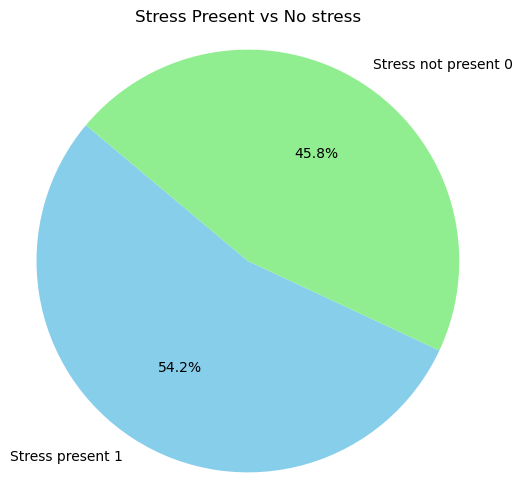

In [17]:
import matplotlib.pyplot as plt

# Sample binary dataset
labels = ['Stress present 1', 'Stress not present 0']
sizes=[sum(1 for label in df['label'] if label == 1),sum(1 for label in df['label'] if label == 0)]

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen'])

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.title('Stress Present vs No stress')
plt.show()

# Modeling Imports

In [3]:
from sklearn.model_selection import train_test_split

import tensorflow as tf

2024-04-03 22:46:35.539226: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 22:46:35.603458: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 22:46:36.769816: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
RANDOM_VALUE = 42
VOCAB_SIZE = 10_000

Split into train, validation, and test sets before vectorizing.

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df['processed_text'], df['label'],
    test_size=0.3, random_state=RANDOM_VALUE
)
X_train.shape, y_train.shape

((15842,), (15842,))

In [6]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5, random_state=RANDOM_VALUE
)
X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3395,), (3395,), (3395,), (3395,))

# ML with TF-IDF Embedding

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

## TF-IDF Embedding

No tokens appeared more often than across 60% of the texts, so a threshold was applied to keep this embedding comparable.

In [45]:
td_vectorizer = TfidfVectorizer(
    max_features=VOCAB_SIZE
)
X_train_tfidf = td_vectorizer.fit_transform(X_train)
len(td_vectorizer.vocabulary_)

10000

In [49]:
X_val_tfidf = td_vectorizer.transform(X_val)
X_test_tfidf = td_vectorizer.transform(X_test)
X_val_tfidf.shape, X_test_tfidf.shape

((3395, 10000), (3395, 10000))

## Models

### Logistic Regression

[[1429  114]
 [ 145 1707]]


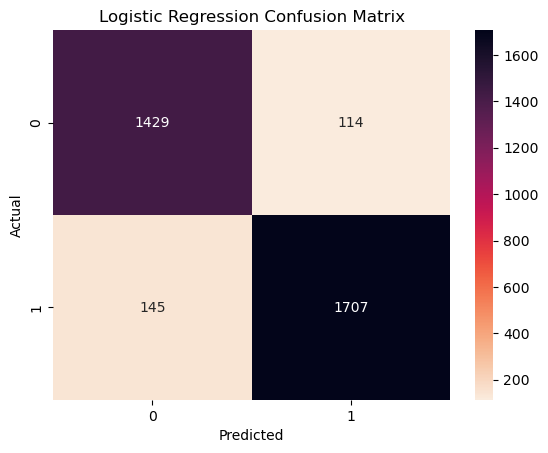

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1543
           1       0.94      0.92      0.93      1852

    accuracy                           0.92      3395
   macro avg       0.92      0.92      0.92      3395
weighted avg       0.92      0.92      0.92      3395



In [50]:
logreg = LogisticRegression().fit(X_train_tfidf, y_train)
utils.get_classification_report(
    model=logreg,
    features=X_test_tfidf,
    target=y_test,
    plot_title='Logistic Regression Confusion Matrix'
)

### Naive Bayes

[[1321   90]
 [ 253 1731]]


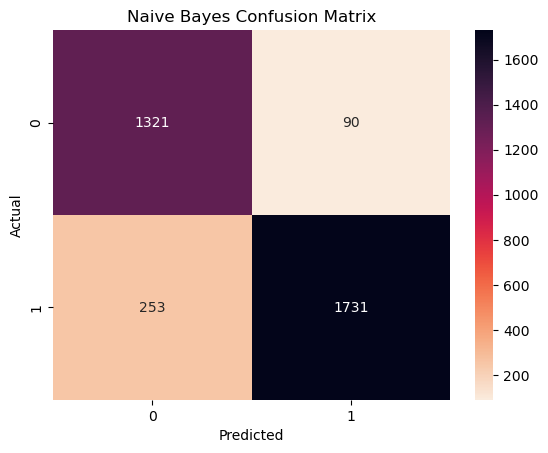

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1411
           1       0.95      0.87      0.91      1984

    accuracy                           0.90      3395
   macro avg       0.89      0.90      0.90      3395
weighted avg       0.90      0.90      0.90      3395



In [51]:
bayes = MultinomialNB().fit(X_train_tfidf, y_train)
utils.get_classification_report(
    model=bayes,
    features=X_test_tfidf,
    target=y_test,
    plot_title='Naive Bayes Confusion Matrix'
)

### Random Forest

[[1396  131]
 [ 178 1690]]


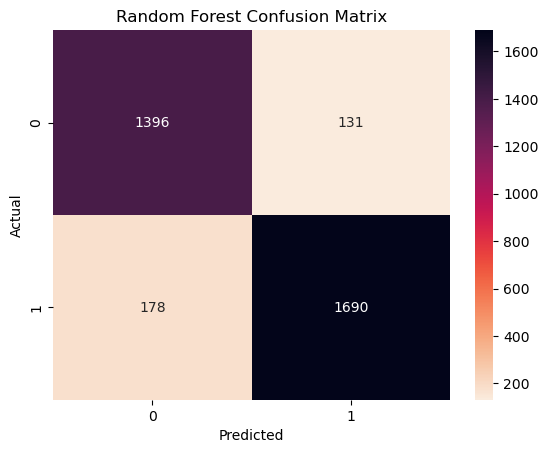

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1527
           1       0.93      0.90      0.92      1868

    accuracy                           0.91      3395
   macro avg       0.91      0.91      0.91      3395
weighted avg       0.91      0.91      0.91      3395



In [52]:
rf = RandomForestClassifier().fit(X_train_tfidf, y_train)
utils.get_classification_report(
    model=rf,
    features=X_test_tfidf,
    target=y_test,
    plot_title='Random Forest Confusion Matrix'
)

# (Optional) GPU Check

In [7]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
print(tf.__version__)
print('Number of GPUs available:', len(
    tf.config.experimental.list_physical_devices('GPU')
))
!python --version

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1834466703076120334
xla_global_id: -1
]
2.16.1
Number of GPUs available: 0


2024-04-03 22:46:50.249637: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-03 22:46:50.256312: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-04-03 22:46:50.314336: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/li

Python 3.10.13


# Deep Learning Embeddings

In [33]:
from tensorflow.keras import layers
from sklearn.metrics import classification_report

## Default TensorFlow

In [8]:
X_train_tensor = tf.convert_to_tensor(X_train)
X_val_tensor = tf.convert_to_tensor(X_val)
X_test_tensor = tf.convert_to_tensor(X_test)

In [9]:
y_train_tensor = tf.convert_to_tensor(y_train)
y_val_tensor = tf.convert_to_tensor(y_val)
y_test_tensor = tf.convert_to_tensor(y_test)

In [10]:
text_vect = layers.TextVectorization(
    output_mode='int',
    max_tokens=VOCAB_SIZE,
)

# Train the vectorizer
text_vect.adapt(X_train)

In [11]:
X_train_default = text_vect(X_train)
X_val_default = text_vect(X_val)
X_test_default = text_vect(X_test)

In [12]:
BUFFER_SIZE = 5000
BATCH_SIZE = 32
EPOCHS = 50
PATIENCE = 3

# CNN

# RNN

In [14]:
inputs = tf.keras.Input(shape=(None,), dtype='int64')
embedded = layers.Embedding(
    input_dim=X_train_default.shape[0], output_dim=256, mask_zero=True
)(inputs)

# Bidirectional LSTM
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)

# Classification layer
outputs = layers.Dense(1, activation='sigmoid')(x)

rnn_model = tf.keras.Model(inputs, outputs)

In [15]:
rnn_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │  4,055,552 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64)        │     73,984 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,129,601 (15.75 MB)

 Trainable params: 4,129,601 (15.75 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
rnn_early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=PATIENCE
)
rnn_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'rnn.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

In [18]:
rnn_history = rnn_model.fit(
    X_train_default, y_train, validation_data=(X_val_default, y_val), 
    batch_size=BATCH_SIZE, epochs=EPOCHS, 
    callbacks=[rnn_early_stop_callback, rnn_checkpoint_callback]
)

Epoch 1/50


2024-04-03 22:47:50.217270: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


496/496 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6853 - loss: 0.5671
Epoch 1: val_loss improved from inf to 0.21562, saving model to rnn.keras
496/496 ━━━━━━━━━━━━━━━━━━━━ 56s 104ms/step - accuracy: 0.6855 - loss: 0.5668 - val_accuracy: 0.9128 - val_loss: 0.2156
Epoch 2/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9405 - loss: 0.1531
Epoch 2: val_loss improved from 0.21562 to 0.17704, saving model to rnn.keras
496/496 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - accuracy: 0.9405 - loss: 0.1531 - val_accuracy: 0.9261 - val_loss: 0.1770
Epoch 3/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9621 - loss: 0.1003
Epoch 3: val_loss improved from 0.17704 to 0.16693, saving model to rnn.keras
496/496 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - accuracy: 0.9621 - loss: 0.1003 - val_accuracy: 0.9361 - val_loss: 0.1669
Epoch 4/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9765 - loss: 0.0705
Epoch 4: val_loss did not improve from 0.16693
496/496 ━━━━━━━━━━━━━━━━━━

In [27]:
rnn_pred = rnn_model.predict(X_test_default).round()

107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


Confusion matrix, without normalization


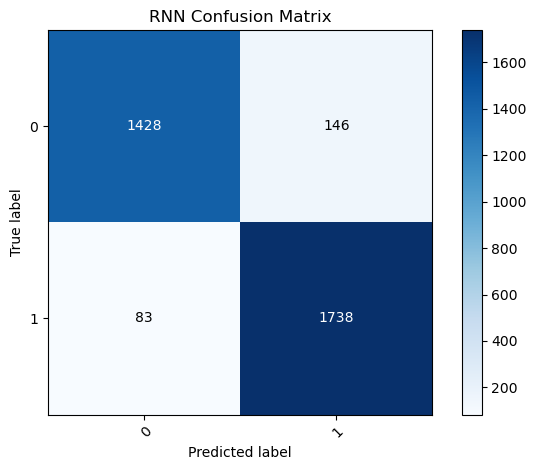

In [32]:
rnn_ax = utils.plot_confusion_matrix(y_true=y_test, y_pred=rnn_pred, classes=['0', '1'], title='RNN Confusion Matrix')
plt.show()

In [35]:
print(classification_report(rnn_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93      1511
         1.0       0.95      0.92      0.94      1884

    accuracy                           0.93      3395
   macro avg       0.93      0.93      0.93      3395
weighted avg       0.93      0.93      0.93      3395



# LSTM

# One-Off Tests

In [58]:
from nltk.stem import WordNetLemmatizer

def predict_stress(text, model, vectorizer):
    output = 'Stress NOT detected'
    
    processed = utils.process_text(text, md.STOPWORDS, WordNetLemmatizer())
    embedding = vectorizer.transform([processed])
    result = model.predict(embedding)
    if result[0] == 1:
        output = 'STRESS detected'
    
    return output

In [54]:
test_text = 'Hi, I need help!'

In [61]:
models = [logreg, bayes, rf]
model_names = ['Logistic Regression', 'Naive Bayes', 'Random Forest']

In [63]:
for m, name in zip(models, model_names):
    print(f'{name}: {predict_stress(test_text, m, td_vectorizer)}')

Logistic Regression: Stress NOT detected
Naive Bayes: Stress NOT detected
Random Forest: STRESS detected
